In [ ]:
%tensorflow_version 1.x
!pip install keras-vggface
!pip install scikit-image
!pip install pydot

TensorFlow 1.x selected.


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.python.lib.io import file_io

%matplotlib inline

import keras
from keras import backend as K
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator
from keras_vggface.vggface import VGGFace
from keras.utils import plot_model
from sklearn.metrics import *
from keras.engine import Model
from keras.layers import Input, Flatten, Dense, Activation, Conv2D, MaxPool2D, BatchNormalization, Dropout, MaxPooling2D
import skimage
from skimage.transform import rescale, resize

import pydot

Using TensorFlow backend.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
print(tf.__version__)
print(keras.__version__)

1.15.2
2.3.1


In [ ]:
EPOCHS = 50
BS = 128
DROPOUT_RATE = 0.5
FROZEN_LAYER_NUM = 170

ADAM_LEARNING_RATE = 0.001
SGD_LEARNING_RATE = 0.01
SGD_DECAY = 0.0001

Resize_pixelsize = 197

In [ ]:
vgg_notop = VGGFace(model='resnet50', include_top=False, input_shape=(Resize_pixelsize, Resize_pixelsize, 3), pooling='avg')
last_layer = vgg_notop.get_layer('avg_pool').output
x = Flatten(name='flatten')(last_layer)
x = Dropout(DROPOUT_RATE)(x)
x = Dense(4096, activation='relu', name='fc6')(x)
x = Dropout(DROPOUT_RATE)(x)
x = Dense(1024, activation='relu', name='fc7')(x)
x = Dropout(DROPOUT_RATE)(x)

batch_norm_indices = [2, 6, 9, 13, 14, 18, 21, 24, 28, 31, 34, 38, 41, 45, 46, 53, 56, 60, 63, 66, 70, 73, 76, 80, 83, 87, 88, 92, 95, 98, 102, 105, 108, 112, 115, 118, 122, 125, 128, 132, 135, 138, 142, 145, 149, 150, 154, 157, 160, 164, 167, 170]
for i in range(FROZEN_LAYER_NUM):
    if i not in batch_norm_indices:
        vgg_notop.layers[i].trainable = False


out = Dense(7, activation='softmax', name='classifier')(x)

model = Model(vgg_notop.input, out)


optim = keras.optimizers.Adam(lr=ADAM_LEARNING_RATE, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
sgd = keras.optimizers.SGD(lr=SGD_LEARNING_RATE, momentum=0.9, decay=SGD_DECAY, nesterov=True)
rlrop = keras.callbacks.ReduceLROnPlateau(monitor='val_acc',mode='max',factor=0.5, patience=10, min_lr=0.00001, verbose=1)

model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
! rm -rf train; mkdir train
! unzip -q '/content/drive/My Drive/Facial Expression/Facial_Expression/train.zip' -d train

In [ ]:
! rm -rf dev; mkdir dev
! unzip -q '/content/drive/My Drive/Facial Expression/Facial_Expression/test-public.zip' -d dev
! rm -rf test; mkdir test
! unzip -q '/content/drive/My Drive/Facial Expression/Facial_Expression/test-private.zip' -d test

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def get_datagen(dataset, aug=False):
    if aug:
        datagen = ImageDataGenerator(
                            rescale=1./255,
                            featurewise_center=False,
                            featurewise_std_normalization=False,
                            rotation_range=10,
                            width_shift_range=0.1,
                            height_shift_range=0.1,
                            zoom_range=0.1,
                            horizontal_flip=True)
    else:
        datagen = ImageDataGenerator(rescale=1./255)

    return datagen.flow_from_directory(
            dataset,
            target_size=(197, 197),
            color_mode='rgb',
            shuffle = True,
            class_mode='categorical',
            batch_size=BS)

In [ ]:
train_generator  = get_datagen('/content/train', True)
dev_generator    = get_datagen('/content/dev')
test_generator  = get_datagen('/content/test')

Found 28709 images belonging to 7 classes.
Found 3589 images belonging to 7 classes.
Found 3589 images belonging to 7 classes.


In [ ]:
history = model.fit_generator(
    generator = train_generator,
    validation_data=dev_generator, 
    steps_per_epoch=28709// BS,
    validation_steps=3509 // BS,
    shuffle=True,
    epochs=100,
    callbacks=[rlrop],
    use_multiprocessing=True,
)


Epoch 1/100


/tensorflow-1.15.2/python3.7/keras/utils/data_utils.py:616: UserWarning: The input 117 could not be retrieved. It could be because a worker has died.
  UserWarning)


  1/224 [..............................] - ETA: 2:24:36 - loss: 5.9306 - accuracy: 0.2031

/tensorflow-1.15.2/python3.7/keras/utils/data_utils.py:616: UserWarning: The input 105 could not be retrieved. It could be because a worker has died.
  UserWarning)


  2/224 [..............................] - ETA: 2:10:02 - loss: 8.1682 - accuracy: 0.2227

/tensorflow-1.15.2/python3.7/keras/utils/data_utils.py:616: UserWarning: The input 157 could not be retrieved. It could be because a worker has died.
  UserWarning)


  3/224 [..............................] - ETA: 2:04:49 - loss: 9.1568 - accuracy: 0.2031

/tensorflow-1.15.2/python3.7/keras/utils/data_utils.py:616: UserWarning: The input 28 could not be retrieved. It could be because a worker has died.
  UserWarning)


  4/224 [..............................] - ETA: 2:01:56 - loss: 10.3392 - accuracy: 0.1855

/tensorflow-1.15.2/python3.7/keras/utils/data_utils.py:616: UserWarning: The input 7 could not be retrieved. It could be because a worker has died.
  UserWarning)


  5/224 [..............................] - ETA: 2:00:00 - loss: 9.4533 - accuracy: 0.1953 

/tensorflow-1.15.2/python3.7/keras/utils/data_utils.py:616: UserWarning: The input 115 could not be retrieved. It could be because a worker has died.
  UserWarning)


  6/224 [..............................] - ETA: 1:58:32 - loss: 8.7481 - accuracy: 0.2031

/tensorflow-1.15.2/python3.7/keras/utils/data_utils.py:616: UserWarning: The input 178 could not be retrieved. It could be because a worker has died.
  UserWarning)


  7/224 [..............................] - ETA: 1:57:21 - loss: 8.0859 - accuracy: 0.1942

/tensorflow-1.15.2/python3.7/keras/utils/data_utils.py:616: UserWarning: The input 108 could not be retrieved. It could be because a worker has died.
  UserWarning)


  8/224 [>.............................] - ETA: 1:56:19 - loss: 7.4051 - accuracy: 0.2002

/tensorflow-1.15.2/python3.7/keras/utils/data_utils.py:616: UserWarning: The input 39 could not be retrieved. It could be because a worker has died.
  UserWarning)


  9/224 [>.............................] - ETA: 1:55:24 - loss: 6.8396 - accuracy: 0.2023

/tensorflow-1.15.2/python3.7/keras/utils/data_utils.py:616: UserWarning: The input 75 could not be retrieved. It could be because a worker has died.
  UserWarning)


 10/224 [>.............................] - ETA: 1:54:34 - loss: 6.3767 - accuracy: 0.2008

/tensorflow-1.15.2/python3.7/keras/utils/data_utils.py:616: UserWarning: The input 158 could not be retrieved. It could be because a worker has died.
  UserWarning)


 11/224 [>.............................] - ETA: 1:53:47 - loss: 5.9868 - accuracy: 0.1996

/tensorflow-1.15.2/python3.7/keras/utils/data_utils.py:616: UserWarning: The input 12 could not be retrieved. It could be because a worker has died.
  UserWarning)


 12/224 [>.............................] - ETA: 1:53:03 - loss: 5.6518 - accuracy: 0.2005

/tensorflow-1.15.2/python3.7/keras/utils/data_utils.py:616: UserWarning: The input 26 could not be retrieved. It could be because a worker has died.
  UserWarning)


 13/224 [>.............................] - ETA: 1:52:21 - loss: 5.3646 - accuracy: 0.2031

/tensorflow-1.15.2/python3.7/keras/utils/data_utils.py:616: UserWarning: The input 1 could not be retrieved. It could be because a worker has died.
  UserWarning)


 14/224 [>.............................] - ETA: 1:51:40 - loss: 5.1233 - accuracy: 0.2026

/tensorflow-1.15.2/python3.7/keras/utils/data_utils.py:616: UserWarning: The input 77 could not be retrieved. It could be because a worker has died.
  UserWarning)


 15/224 [=>............................] - ETA: 1:51:02 - loss: 4.9110 - accuracy: 0.2047

/tensorflow-1.15.2/python3.7/keras/utils/data_utils.py:616: UserWarning: The input 183 could not be retrieved. It could be because a worker has died.
  UserWarning)


 16/224 [=>............................] - ETA: 1:50:23 - loss: 4.7177 - accuracy: 0.2075

/tensorflow-1.15.2/python3.7/keras/utils/data_utils.py:616: UserWarning: The input 162 could not be retrieved. It could be because a worker has died.
  UserWarning)


 17/224 [=>............................] - ETA: 1:49:46 - loss: 4.5508 - accuracy: 0.2068

/tensorflow-1.15.2/python3.7/keras/utils/data_utils.py:616: UserWarning: The input 82 could not be retrieved. It could be because a worker has died.
  UserWarning)


 18/224 [=>............................] - ETA: 1:49:09 - loss: 4.4010 - accuracy: 0.2096

/tensorflow-1.15.2/python3.7/keras/utils/data_utils.py:616: UserWarning: The input 111 could not be retrieved. It could be because a worker has died.
  UserWarning)


 19/224 [=>............................] - ETA: 1:48:35 - loss: 4.2704 - accuracy: 0.2101

/tensorflow-1.15.2/python3.7/keras/utils/data_utils.py:616: UserWarning: The input 198 could not be retrieved. It could be because a worker has died.
  UserWarning)


 20/224 [=>............................] - ETA: 1:47:59 - loss: 4.1450 - accuracy: 0.2105

/tensorflow-1.15.2/python3.7/keras/utils/data_utils.py:616: UserWarning: The input 192 could not be retrieved. It could be because a worker has died.
  UserWarning)


 21/224 [=>............................] - ETA: 1:47:23 - loss: 4.0360 - accuracy: 0.2121

/tensorflow-1.15.2/python3.7/keras/utils/data_utils.py:616: UserWarning: The input 124 could not be retrieved. It could be because a worker has died.
  UserWarning)


 22/224 [=>............................] - ETA: 1:46:48 - loss: 3.9396 - accuracy: 0.2134

/tensorflow-1.15.2/python3.7/keras/utils/data_utils.py:616: UserWarning: The input 123 could not be retrieved. It could be because a worker has died.
  UserWarning)


 23/224 [==>...........................] - ETA: 1:46:13 - loss: 3.8527 - accuracy: 0.2140

/tensorflow-1.15.2/python3.7/keras/utils/data_utils.py:616: UserWarning: The input 199 could not be retrieved. It could be because a worker has died.
  UserWarning)


 24/224 [==>...........................] - ETA: 1:45:38 - loss: 3.7662 - accuracy: 0.2165

/tensorflow-1.15.2/python3.7/keras/utils/data_utils.py:616: UserWarning: The input 70 could not be retrieved. It could be because a worker has died.
  UserWarning)


 25/224 [==>...........................] - ETA: 1:45:04 - loss: 3.6879 - accuracy: 0.2172

/tensorflow-1.15.2/python3.7/keras/utils/data_utils.py:616: UserWarning: The input 177 could not be retrieved. It could be because a worker has died.
  UserWarning)


 26/224 [==>...........................] - ETA: 1:44:30 - loss: 3.6164 - accuracy: 0.2203

/tensorflow-1.15.2/python3.7/keras/utils/data_utils.py:616: UserWarning: The input 87 could not be retrieved. It could be because a worker has died.
  UserWarning)


 27/224 [==>...........................] - ETA: 1:43:56 - loss: 3.5505 - accuracy: 0.2208

/tensorflow-1.15.2/python3.7/keras/utils/data_utils.py:616: UserWarning: The input 83 could not be retrieved. It could be because a worker has died.
  UserWarning)


 28/224 [==>...........................] - ETA: 1:43:22 - loss: 3.4900 - accuracy: 0.2204

/tensorflow-1.15.2/python3.7/keras/utils/data_utils.py:616: UserWarning: The input 137 could not be retrieved. It could be because a worker has died.
  UserWarning)


 29/224 [==>...........................] - ETA: 1:42:49 - loss: 3.4329 - accuracy: 0.2223

/tensorflow-1.15.2/python3.7/keras/utils/data_utils.py:616: UserWarning: The input 85 could not be retrieved. It could be because a worker has died.
  UserWarning)


 30/224 [===>..........................] - ETA: 1:42:15 - loss: 3.3824 - accuracy: 0.2227

/tensorflow-1.15.2/python3.7/keras/utils/data_utils.py:616: UserWarning: The input 122 could not be retrieved. It could be because a worker has died.
  UserWarning)


 31/224 [===>..........................] - ETA: 1:41:42 - loss: 3.3321 - accuracy: 0.2228

/tensorflow-1.15.2/python3.7/keras/utils/data_utils.py:616: UserWarning: The input 29 could not be retrieved. It could be because a worker has died.
  UserWarning)


 32/224 [===>..........................] - ETA: 1:41:09 - loss: 3.2870 - accuracy: 0.2224

/tensorflow-1.15.2/python3.7/keras/utils/data_utils.py:616: UserWarning: The input 101 could not be retrieved. It could be because a worker has died.
  UserWarning)


 33/224 [===>..........................] - ETA: 1:40:36 - loss: 3.2430 - accuracy: 0.2232

/tensorflow-1.15.2/python3.7/keras/utils/data_utils.py:616: UserWarning: The input 5 could not be retrieved. It could be because a worker has died.
  UserWarning)


 34/224 [===>..........................] - ETA: 1:40:03 - loss: 3.2038 - accuracy: 0.2222

/tensorflow-1.15.2/python3.7/keras/utils/data_utils.py:616: UserWarning: The input 223 could not be retrieved. It could be because a worker has died.
  UserWarning)


 35/224 [===>..........................] - ETA: 1:39:30 - loss: 3.1635 - accuracy: 0.2232

/tensorflow-1.15.2/python3.7/keras/utils/data_utils.py:616: UserWarning: The input 34 could not be retrieved. It could be because a worker has died.
  UserWarning)


 36/224 [===>..........................] - ETA: 1:38:58 - loss: 3.1271 - accuracy: 0.2229

/tensorflow-1.15.2/python3.7/keras/utils/data_utils.py:616: UserWarning: The input 141 could not be retrieved. It could be because a worker has died.
  UserWarning)


 37/224 [===>..........................] - ETA: 1:38:25 - loss: 3.0904 - accuracy: 0.2238

/tensorflow-1.15.2/python3.7/keras/utils/data_utils.py:616: UserWarning: The input 81 could not be retrieved. It could be because a worker has died.
  UserWarning)


 38/224 [====>.........................] - ETA: 1:37:52 - loss: 3.0565 - accuracy: 0.2243

/tensorflow-1.15.2/python3.7/keras/utils/data_utils.py:616: UserWarning: The input 134 could not be retrieved. It could be because a worker has died.
  UserWarning)


 39/224 [====>.........................] - ETA: 1:37:20 - loss: 3.0248 - accuracy: 0.2252

/tensorflow-1.15.2/python3.7/keras/utils/data_utils.py:616: UserWarning: The input 118 could not be retrieved. It could be because a worker has died.
  UserWarning)


 40/224 [====>.........................] - ETA: 1:36:47 - loss: 2.9930 - accuracy: 0.2248

/tensorflow-1.15.2/python3.7/keras/utils/data_utils.py:616: UserWarning: The input 59 could not be retrieved. It could be because a worker has died.
  UserWarning)


 41/224 [====>.........................] - ETA: 1:36:15 - loss: 2.9659 - accuracy: 0.2247

/tensorflow-1.15.2/python3.7/keras/utils/data_utils.py:616: UserWarning: The input 194 could not be retrieved. It could be because a worker has died.
  UserWarning)


 42/224 [====>.........................] - ETA: 1:35:42 - loss: 2.9387 - accuracy: 0.2240

/tensorflow-1.15.2/python3.7/keras/utils/data_utils.py:616: UserWarning: The input 208 could not be retrieved. It could be because a worker has died.
  UserWarning)


 43/224 [====>.........................] - ETA: 1:35:10 - loss: 2.9131 - accuracy: 0.2247

/tensorflow-1.15.2/python3.7/keras/utils/data_utils.py:616: UserWarning: The input 120 could not be retrieved. It could be because a worker has died.
  UserWarning)


 44/224 [====>.........................] - ETA: 1:34:38 - loss: 2.8865 - accuracy: 0.2257

/tensorflow-1.15.2/python3.7/keras/utils/data_utils.py:616: UserWarning: The input 119 could not be retrieved. It could be because a worker has died.
  UserWarning)


 45/224 [=====>........................] - ETA: 1:34:06 - loss: 2.8608 - accuracy: 0.2273

/tensorflow-1.15.2/python3.7/keras/utils/data_utils.py:616: UserWarning: The input 139 could not be retrieved. It could be because a worker has died.
  UserWarning)


 46/224 [=====>........................] - ETA: 1:33:34 - loss: 2.8380 - accuracy: 0.2281

/tensorflow-1.15.2/python3.7/keras/utils/data_utils.py:616: UserWarning: The input 112 could not be retrieved. It could be because a worker has died.
  UserWarning)


 47/224 [=====>........................] - ETA: 1:33:01 - loss: 2.8167 - accuracy: 0.2279

/tensorflow-1.15.2/python3.7/keras/utils/data_utils.py:616: UserWarning: The input 61 could not be retrieved. It could be because a worker has died.
  UserWarning)


 48/224 [=====>........................] - ETA: 1:32:29 - loss: 2.7955 - accuracy: 0.2280

/tensorflow-1.15.2/python3.7/keras/utils/data_utils.py:616: UserWarning: The input 15 could not be retrieved. It could be because a worker has died.
  UserWarning)


 49/224 [=====>........................] - ETA: 1:31:57 - loss: 2.7738 - accuracy: 0.2286

/tensorflow-1.15.2/python3.7/keras/utils/data_utils.py:616: UserWarning: The input 221 could not be retrieved. It could be because a worker has died.
  UserWarning)


 50/224 [=====>........................] - ETA: 1:31:25 - loss: 2.7545 - accuracy: 0.2302

/tensorflow-1.15.2/python3.7/keras/utils/data_utils.py:616: UserWarning: The input 200 could not be retrieved. It could be because a worker has died.
  UserWarning)


 51/224 [=====>........................] - ETA: 1:30:53 - loss: 2.7339 - accuracy: 0.2310

/tensorflow-1.15.2/python3.7/keras/utils/data_utils.py:616: UserWarning: The input 37 could not be retrieved. It could be because a worker has died.
  UserWarning)


 52/224 [=====>........................] - ETA: 1:30:21 - loss: 2.7158 - accuracy: 0.2323

/tensorflow-1.15.2/python3.7/keras/utils/data_utils.py:616: UserWarning: The input 164 could not be retrieved. It could be because a worker has died.
  UserWarning)


 53/224 [======>.......................] - ETA: 1:29:49 - loss: 2.6984 - accuracy: 0.2335

/tensorflow-1.15.2/python3.7/keras/utils/data_utils.py:616: UserWarning: The input 176 could not be retrieved. It could be because a worker has died.
  UserWarning)


 54/224 [======>.......................] - ETA: 1:29:17 - loss: 2.6837 - accuracy: 0.2331

/tensorflow-1.15.2/python3.7/keras/utils/data_utils.py:616: UserWarning: The input 56 could not be retrieved. It could be because a worker has died.
  UserWarning)


 55/224 [======>.......................] - ETA: 1:28:45 - loss: 2.6651 - accuracy: 0.2357

/tensorflow-1.15.2/python3.7/keras/utils/data_utils.py:616: UserWarning: The input 135 could not be retrieved. It could be because a worker has died.
  UserWarning)


 56/224 [======>.......................] - ETA: 1:28:13 - loss: 2.6494 - accuracy: 0.2373

/tensorflow-1.15.2/python3.7/keras/utils/data_utils.py:616: UserWarning: The input 16 could not be retrieved. It could be because a worker has died.
  UserWarning)


 57/224 [======>.......................] - ETA: 1:27:41 - loss: 2.6346 - accuracy: 0.2377

/tensorflow-1.15.2/python3.7/keras/utils/data_utils.py:616: UserWarning: The input 43 could not be retrieved. It could be because a worker has died.
  UserWarning)


 58/224 [======>.......................] - ETA: 1:27:09 - loss: 2.6205 - accuracy: 0.2376

/tensorflow-1.15.2/python3.7/keras/utils/data_utils.py:616: UserWarning: The input 106 could not be retrieved. It could be because a worker has died.
  UserWarning)


 59/224 [======>.......................] - ETA: 1:26:37 - loss: 2.6055 - accuracy: 0.2387

/tensorflow-1.15.2/python3.7/keras/utils/data_utils.py:616: UserWarning: The input 32 could not be retrieved. It could be because a worker has died.
  UserWarning)


 60/224 [=======>......................] - ETA: 1:26:06 - loss: 2.5925 - accuracy: 0.2392

/tensorflow-1.15.2/python3.7/keras/utils/data_utils.py:616: UserWarning: The input 60 could not be retrieved. It could be because a worker has died.
  UserWarning)


 61/224 [=======>......................] - ETA: 1:25:34 - loss: 2.5782 - accuracy: 0.2409

/tensorflow-1.15.2/python3.7/keras/utils/data_utils.py:616: UserWarning: The input 47 could not be retrieved. It could be because a worker has died.
  UserWarning)


 62/224 [=======>......................] - ETA: 1:25:02 - loss: 2.5633 - accuracy: 0.2421

/tensorflow-1.15.2/python3.7/keras/utils/data_utils.py:616: UserWarning: The input 184 could not be retrieved. It could be because a worker has died.
  UserWarning)


 63/224 [=======>......................] - ETA: 1:24:30 - loss: 2.5499 - accuracy: 0.2438

/tensorflow-1.15.2/python3.7/keras/utils/data_utils.py:616: UserWarning: The input 76 could not be retrieved. It could be because a worker has died.
  UserWarning)


 64/224 [=======>......................] - ETA: 1:23:58 - loss: 2.5377 - accuracy: 0.2445

/tensorflow-1.15.2/python3.7/keras/utils/data_utils.py:616: UserWarning: The input 142 could not be retrieved. It could be because a worker has died.
  UserWarning)


 65/224 [=======>......................] - ETA: 1:23:26 - loss: 2.5255 - accuracy: 0.2453

/tensorflow-1.15.2/python3.7/keras/utils/data_utils.py:616: UserWarning: The input 204 could not be retrieved. It could be because a worker has died.
  UserWarning)


 66/224 [=======>......................] - ETA: 1:22:55 - loss: 2.5138 - accuracy: 0.2466

/tensorflow-1.15.2/python3.7/keras/utils/data_utils.py:616: UserWarning: The input 100 could not be retrieved. It could be because a worker has died.
  UserWarning)


 67/224 [=======>......................] - ETA: 1:22:23 - loss: 2.5034 - accuracy: 0.2463

/tensorflow-1.15.2/python3.7/keras/utils/data_utils.py:616: UserWarning: The input 138 could not be retrieved. It could be because a worker has died.
  UserWarning)


 68/224 [========>.....................] - ETA: 1:21:51 - loss: 2.4923 - accuracy: 0.2474

/tensorflow-1.15.2/python3.7/keras/utils/data_utils.py:616: UserWarning: The input 215 could not be retrieved. It could be because a worker has died.
  UserWarning)


 69/224 [========>.....................] - ETA: 1:21:19 - loss: 2.4822 - accuracy: 0.2483

/tensorflow-1.15.2/python3.7/keras/utils/data_utils.py:616: UserWarning: The input 46 could not be retrieved. It could be because a worker has died.
  UserWarning)


 70/224 [========>.....................] - ETA: 1:20:48 - loss: 2.4704 - accuracy: 0.2499

/tensorflow-1.15.2/python3.7/keras/utils/data_utils.py:616: UserWarning: The input 179 could not be retrieved. It could be because a worker has died.
  UserWarning)


 71/224 [========>.....................] - ETA: 1:20:16 - loss: 2.4603 - accuracy: 0.2511

/tensorflow-1.15.2/python3.7/keras/utils/data_utils.py:616: UserWarning: The input 6 could not be retrieved. It could be because a worker has died.
  UserWarning)


 72/224 [========>.....................] - ETA: 1:19:44 - loss: 2.4493 - accuracy: 0.2517

/tensorflow-1.15.2/python3.7/keras/utils/data_utils.py:616: UserWarning: The input 66 could not be retrieved. It could be because a worker has died.
  UserWarning)


 73/224 [========>.....................] - ETA: 1:19:12 - loss: 2.4395 - accuracy: 0.2529

/tensorflow-1.15.2/python3.7/keras/utils/data_utils.py:616: UserWarning: The input 143 could not be retrieved. It could be because a worker has died.
  UserWarning)


 74/224 [========>.....................] - ETA: 1:18:41 - loss: 2.4295 - accuracy: 0.2532

/tensorflow-1.15.2/python3.7/keras/utils/data_utils.py:616: UserWarning: The input 54 could not be retrieved. It could be because a worker has died.
  UserWarning)


 75/224 [=========>....................] - ETA: 1:18:09 - loss: 2.4206 - accuracy: 0.2539

/tensorflow-1.15.2/python3.7/keras/utils/data_utils.py:616: UserWarning: The input 97 could not be retrieved. It could be because a worker has died.
  UserWarning)


 76/224 [=========>....................] - ETA: 1:17:37 - loss: 2.4123 - accuracy: 0.2541

/tensorflow-1.15.2/python3.7/keras/utils/data_utils.py:616: UserWarning: The input 96 could not be retrieved. It could be because a worker has died.
  UserWarning)


 77/224 [=========>....................] - ETA: 1:17:06 - loss: 2.4032 - accuracy: 0.2548

/tensorflow-1.15.2/python3.7/keras/utils/data_utils.py:616: UserWarning: The input 193 could not be retrieved. It could be because a worker has died.
  UserWarning)


 78/224 [=========>....................] - ETA: 1:16:34 - loss: 2.3938 - accuracy: 0.2554

/tensorflow-1.15.2/python3.7/keras/utils/data_utils.py:616: UserWarning: The input 11 could not be retrieved. It could be because a worker has died.
  UserWarning)


 79/224 [=========>....................] - ETA: 1:16:02 - loss: 2.3849 - accuracy: 0.2566

/tensorflow-1.15.2/python3.7/keras/utils/data_utils.py:616: UserWarning: The input 156 could not be retrieved. It could be because a worker has died.
  UserWarning)


 80/224 [=========>....................] - ETA: 1:15:31 - loss: 2.3745 - accuracy: 0.2582

/tensorflow-1.15.2/python3.7/keras/utils/data_utils.py:616: UserWarning: The input 160 could not be retrieved. It could be because a worker has died.
  UserWarning)


 81/224 [=========>....................] - ETA: 1:14:59 - loss: 2.3673 - accuracy: 0.2585

/tensorflow-1.15.2/python3.7/keras/utils/data_utils.py:616: UserWarning: The input 209 could not be retrieved. It could be because a worker has died.
  UserWarning)


 82/224 [=========>....................] - ETA: 1:14:27 - loss: 2.3586 - accuracy: 0.2598

/tensorflow-1.15.2/python3.7/keras/utils/data_utils.py:616: UserWarning: The input 168 could not be retrieved. It could be because a worker has died.
  UserWarning)


 83/224 [==========>...................] - ETA: 1:13:56 - loss: 2.3513 - accuracy: 0.2607

/tensorflow-1.15.2/python3.7/keras/utils/data_utils.py:616: UserWarning: The input 144 could not be retrieved. It could be because a worker has died.
  UserWarning)


 84/224 [==========>...................] - ETA: 1:13:24 - loss: 2.3440 - accuracy: 0.2613

/tensorflow-1.15.2/python3.7/keras/utils/data_utils.py:616: UserWarning: The input 17 could not be retrieved. It could be because a worker has died.
  UserWarning)


 85/224 [==========>...................] - ETA: 1:12:53 - loss: 2.3377 - accuracy: 0.2614

/tensorflow-1.15.2/python3.7/keras/utils/data_utils.py:616: UserWarning: The input 150 could not be retrieved. It could be because a worker has died.
  UserWarning)


 86/224 [==========>...................] - ETA: 1:12:21 - loss: 2.3305 - accuracy: 0.2621

/tensorflow-1.15.2/python3.7/keras/utils/data_utils.py:616: UserWarning: The input 68 could not be retrieved. It could be because a worker has died.
  UserWarning)


 87/224 [==========>...................] - ETA: 1:11:50 - loss: 2.3241 - accuracy: 0.2625

/tensorflow-1.15.2/python3.7/keras/utils/data_utils.py:616: UserWarning: The input 3 could not be retrieved. It could be because a worker has died.
  UserWarning)


 88/224 [==========>...................] - ETA: 1:11:18 - loss: 2.3172 - accuracy: 0.2631

/tensorflow-1.15.2/python3.7/keras/utils/data_utils.py:616: UserWarning: The input 51 could not be retrieved. It could be because a worker has died.
  UserWarning)


 89/224 [==========>...................] - ETA: 1:10:46 - loss: 2.3091 - accuracy: 0.2640

/tensorflow-1.15.2/python3.7/keras/utils/data_utils.py:616: UserWarning: The input 172 could not be retrieved. It could be because a worker has died.
  UserWarning)


 90/224 [===========>..................] - ETA: 1:10:15 - loss: 2.3016 - accuracy: 0.2656

/tensorflow-1.15.2/python3.7/keras/utils/data_utils.py:616: UserWarning: The input 140 could not be retrieved. It could be because a worker has died.
  UserWarning)


 91/224 [===========>..................] - ETA: 1:09:43 - loss: 2.2945 - accuracy: 0.2661

/tensorflow-1.15.2/python3.7/keras/utils/data_utils.py:616: UserWarning: The input 169 could not be retrieved. It could be because a worker has died.
  UserWarning)


 92/224 [===========>..................] - ETA: 1:09:12 - loss: 2.2876 - accuracy: 0.2672

/tensorflow-1.15.2/python3.7/keras/utils/data_utils.py:616: UserWarning: The input 201 could not be retrieved. It could be because a worker has died.
  UserWarning)


 93/224 [===========>..................] - ETA: 1:08:40 - loss: 2.2810 - accuracy: 0.2683

/tensorflow-1.15.2/python3.7/keras/utils/data_utils.py:616: UserWarning: The input 45 could not be retrieved. It could be because a worker has died.
  UserWarning)


 94/224 [===========>..................] - ETA: 1:08:09 - loss: 2.2755 - accuracy: 0.2685

/tensorflow-1.15.2/python3.7/keras/utils/data_utils.py:616: UserWarning: The input 8 could not be retrieved. It could be because a worker has died.
  UserWarning)


 95/224 [===========>..................] - ETA: 1:07:37 - loss: 2.2688 - accuracy: 0.2693

/tensorflow-1.15.2/python3.7/keras/utils/data_utils.py:616: UserWarning: The input 189 could not be retrieved. It could be because a worker has died.
  UserWarning)


 96/224 [===========>..................] - ETA: 1:07:05 - loss: 2.2624 - accuracy: 0.2701

/tensorflow-1.15.2/python3.7/keras/utils/data_utils.py:616: UserWarning: The input 149 could not be retrieved. It could be because a worker has died.
  UserWarning)


 97/224 [===========>..................] - ETA: 1:06:34 - loss: 2.2555 - accuracy: 0.2708

/tensorflow-1.15.2/python3.7/keras/utils/data_utils.py:616: UserWarning: The input 197 could not be retrieved. It could be because a worker has died.
  UserWarning)


 98/224 [============>.................] - ETA: 1:06:03 - loss: 2.2494 - accuracy: 0.2712

/tensorflow-1.15.2/python3.7/keras/utils/data_utils.py:616: UserWarning: The input 187 could not be retrieved. It could be because a worker has died.
  UserWarning)


 99/224 [============>.................] - ETA: 1:05:31 - loss: 2.2433 - accuracy: 0.2718

/tensorflow-1.15.2/python3.7/keras/utils/data_utils.py:616: UserWarning: The input 79 could not be retrieved. It could be because a worker has died.
  UserWarning)


100/224 [============>.................] - ETA: 1:04:59 - loss: 2.2372 - accuracy: 0.2728

/tensorflow-1.15.2/python3.7/keras/utils/data_utils.py:616: UserWarning: The input 10 could not be retrieved. It could be because a worker has died.
  UserWarning)


101/224 [============>.................] - ETA: 1:04:28 - loss: 2.2316 - accuracy: 0.2736

/tensorflow-1.15.2/python3.7/keras/utils/data_utils.py:616: UserWarning: The input 35 could not be retrieved. It could be because a worker has died.
  UserWarning)


102/224 [============>.................] - ETA: 1:03:56 - loss: 2.2251 - accuracy: 0.2748

/tensorflow-1.15.2/python3.7/keras/utils/data_utils.py:616: UserWarning: The input 170 could not be retrieved. It could be because a worker has died.
  UserWarning)


103/224 [============>.................] - ETA: 1:03:25 - loss: 2.2206 - accuracy: 0.2750

/tensorflow-1.15.2/python3.7/keras/utils/data_utils.py:616: UserWarning: The input 31 could not be retrieved. It could be because a worker has died.
  UserWarning)


104/224 [============>.................] - ETA: 1:02:53 - loss: 2.2157 - accuracy: 0.2748

/tensorflow-1.15.2/python3.7/keras/utils/data_utils.py:616: UserWarning: The input 171 could not be retrieved. It could be because a worker has died.
  UserWarning)


105/224 [=============>................] - ETA: 1:02:22 - loss: 2.2114 - accuracy: 0.2751

/tensorflow-1.15.2/python3.7/keras/utils/data_utils.py:616: UserWarning: The input 99 could not be retrieved. It could be because a worker has died.
  UserWarning)


106/224 [=============>................] - ETA: 1:01:50 - loss: 2.2052 - accuracy: 0.2767

/tensorflow-1.15.2/python3.7/keras/utils/data_utils.py:616: UserWarning: The input 121 could not be retrieved. It could be because a worker has died.
  UserWarning)


107/224 [=============>................] - ETA: 1:01:19 - loss: 2.1996 - accuracy: 0.2774

/tensorflow-1.15.2/python3.7/keras/utils/data_utils.py:616: UserWarning: The input 62 could not be retrieved. It could be because a worker has died.
  UserWarning)


108/224 [=============>................] - ETA: 1:00:47 - loss: 2.1938 - accuracy: 0.2783

/tensorflow-1.15.2/python3.7/keras/utils/data_utils.py:616: UserWarning: The input 219 could not be retrieved. It could be because a worker has died.
  UserWarning)


109/224 [=============>................] - ETA: 1:00:16 - loss: 2.1882 - accuracy: 0.2789

/tensorflow-1.15.2/python3.7/keras/utils/data_utils.py:616: UserWarning: The input 41 could not be retrieved. It could be because a worker has died.
  UserWarning)


110/224 [=============>................] - ETA: 59:44 - loss: 2.1815 - accuracy: 0.2805  

/tensorflow-1.15.2/python3.7/keras/utils/data_utils.py:616: UserWarning: The input 25 could not be retrieved. It could be because a worker has died.
  UserWarning)


111/224 [=============>................] - ETA: 59:13 - loss: 2.1764 - accuracy: 0.2816

/tensorflow-1.15.2/python3.7/keras/utils/data_utils.py:616: UserWarning: The input 93 could not be retrieved. It could be because a worker has died.
  UserWarning)


112/224 [==============>...............] - ETA: 58:41 - loss: 2.1710 - accuracy: 0.2824

/tensorflow-1.15.2/python3.7/keras/utils/data_utils.py:616: UserWarning: The input 14 could not be retrieved. It could be because a worker has died.
  UserWarning)


113/224 [==============>...............] - ETA: 58:10 - loss: 2.1661 - accuracy: 0.2834

/tensorflow-1.15.2/python3.7/keras/utils/data_utils.py:616: UserWarning: The input 86 could not be retrieved. It could be because a worker has died.
  UserWarning)


114/224 [==============>...............] - ETA: 57:38 - loss: 2.1604 - accuracy: 0.2843

/tensorflow-1.15.2/python3.7/keras/utils/data_utils.py:616: UserWarning: The input 216 could not be retrieved. It could be because a worker has died.
  UserWarning)


115/224 [==============>...............] - ETA: 57:07 - loss: 2.1558 - accuracy: 0.2849

/tensorflow-1.15.2/python3.7/keras/utils/data_utils.py:616: UserWarning: The input 69 could not be retrieved. It could be because a worker has died.
  UserWarning)


116/224 [==============>...............] - ETA: 56:35 - loss: 2.1513 - accuracy: 0.2852

/tensorflow-1.15.2/python3.7/keras/utils/data_utils.py:616: UserWarning: The input 136 could not be retrieved. It could be because a worker has died.
  UserWarning)


117/224 [==============>...............] - ETA: 56:03 - loss: 2.1462 - accuracy: 0.2865

/tensorflow-1.15.2/python3.7/keras/utils/data_utils.py:616: UserWarning: The input 185 could not be retrieved. It could be because a worker has died.
  UserWarning)


118/224 [==============>...............] - ETA: 55:32 - loss: 2.1408 - accuracy: 0.2871

/tensorflow-1.15.2/python3.7/keras/utils/data_utils.py:616: UserWarning: The input 220 could not be retrieved. It could be because a worker has died.
  UserWarning)


119/224 [==============>...............] - ETA: 55:00 - loss: 2.1379 - accuracy: 0.2871

/tensorflow-1.15.2/python3.7/keras/utils/data_utils.py:616: UserWarning: The input 74 could not be retrieved. It could be because a worker has died.
  UserWarning)


120/224 [===============>..............] - ETA: 54:29 - loss: 2.1339 - accuracy: 0.2875

/tensorflow-1.15.2/python3.7/keras/utils/data_utils.py:616: UserWarning: The input 131 could not be retrieved. It could be because a worker has died.
  UserWarning)


121/224 [===============>..............] - ETA: 53:57 - loss: 2.1289 - accuracy: 0.2886

/tensorflow-1.15.2/python3.7/keras/utils/data_utils.py:616: UserWarning: The input 104 could not be retrieved. It could be because a worker has died.
  UserWarning)


122/224 [===============>..............] - ETA: 53:26 - loss: 2.1233 - accuracy: 0.2900

/tensorflow-1.15.2/python3.7/keras/utils/data_utils.py:616: UserWarning: The input 36 could not be retrieved. It could be because a worker has died.
  UserWarning)


123/224 [===============>..............] - ETA: 52:54 - loss: 2.1191 - accuracy: 0.2905

/tensorflow-1.15.2/python3.7/keras/utils/data_utils.py:616: UserWarning: The input 48 could not be retrieved. It could be because a worker has died.
  UserWarning)


124/224 [===============>..............] - ETA: 52:23 - loss: 2.1161 - accuracy: 0.2907

/tensorflow-1.15.2/python3.7/keras/utils/data_utils.py:616: UserWarning: The input 4 could not be retrieved. It could be because a worker has died.
  UserWarning)


125/224 [===============>..............] - ETA: 51:52 - loss: 2.1112 - accuracy: 0.2919

/tensorflow-1.15.2/python3.7/keras/utils/data_utils.py:616: UserWarning: The input 78 could not be retrieved. It could be because a worker has died.
  UserWarning)


126/224 [===============>..............] - ETA: 51:20 - loss: 2.1063 - accuracy: 0.2932

/tensorflow-1.15.2/python3.7/keras/utils/data_utils.py:616: UserWarning: The input 188 could not be retrieved. It could be because a worker has died.
  UserWarning)


127/224 [================>.............] - ETA: 50:49 - loss: 2.1011 - accuracy: 0.2940

/tensorflow-1.15.2/python3.7/keras/utils/data_utils.py:616: UserWarning: The input 30 could not be retrieved. It could be because a worker has died.
  UserWarning)


128/224 [================>.............] - ETA: 50:17 - loss: 2.0973 - accuracy: 0.2944

/tensorflow-1.15.2/python3.7/keras/utils/data_utils.py:616: UserWarning: The input 196 could not be retrieved. It could be because a worker has died.
  UserWarning)


129/224 [================>.............] - ETA: 49:46 - loss: 2.0943 - accuracy: 0.2949

/tensorflow-1.15.2/python3.7/keras/utils/data_utils.py:616: UserWarning: The input 72 could not be retrieved. It could be because a worker has died.
  UserWarning)


130/224 [================>.............] - ETA: 49:14 - loss: 2.0907 - accuracy: 0.2953

/tensorflow-1.15.2/python3.7/keras/utils/data_utils.py:616: UserWarning: The input 67 could not be retrieved. It could be because a worker has died.
  UserWarning)


131/224 [================>.............] - ETA: 48:43 - loss: 2.0874 - accuracy: 0.2958

/tensorflow-1.15.2/python3.7/keras/utils/data_utils.py:616: UserWarning: The input 151 could not be retrieved. It could be because a worker has died.
  UserWarning)


132/224 [================>.............] - ETA: 48:11 - loss: 2.0841 - accuracy: 0.2963

/tensorflow-1.15.2/python3.7/keras/utils/data_utils.py:616: UserWarning: The input 64 could not be retrieved. It could be because a worker has died.
  UserWarning)


133/224 [================>.............] - ETA: 47:40 - loss: 2.0801 - accuracy: 0.2972

/tensorflow-1.15.2/python3.7/keras/utils/data_utils.py:616: UserWarning: The input 155 could not be retrieved. It could be because a worker has died.
  UserWarning)


134/224 [================>.............] - ETA: 47:08 - loss: 2.0772 - accuracy: 0.2977

/tensorflow-1.15.2/python3.7/keras/utils/data_utils.py:616: UserWarning: The input 206 could not be retrieved. It could be because a worker has died.
  UserWarning)


135/224 [=================>............] - ETA: 46:37 - loss: 2.0726 - accuracy: 0.2984

/tensorflow-1.15.2/python3.7/keras/utils/data_utils.py:616: UserWarning: The input 212 could not be retrieved. It could be because a worker has died.
  UserWarning)


136/224 [=================>............] - ETA: 46:05 - loss: 2.0690 - accuracy: 0.2992

/tensorflow-1.15.2/python3.7/keras/utils/data_utils.py:616: UserWarning: The input 148 could not be retrieved. It could be because a worker has died.
  UserWarning)


137/224 [=================>............] - ETA: 45:34 - loss: 2.0659 - accuracy: 0.2997

/tensorflow-1.15.2/python3.7/keras/utils/data_utils.py:616: UserWarning: The input 202 could not be retrieved. It could be because a worker has died.
  UserWarning)


138/224 [=================>............] - ETA: 45:02 - loss: 2.0618 - accuracy: 0.3008

/tensorflow-1.15.2/python3.7/keras/utils/data_utils.py:616: UserWarning: The input 218 could not be retrieved. It could be because a worker has died.
  UserWarning)


139/224 [=================>............] - ETA: 44:31 - loss: 2.0578 - accuracy: 0.3015

/tensorflow-1.15.2/python3.7/keras/utils/data_utils.py:616: UserWarning: The input 88 could not be retrieved. It could be because a worker has died.
  UserWarning)


140/224 [=================>............] - ETA: 43:59 - loss: 2.0542 - accuracy: 0.3022

/tensorflow-1.15.2/python3.7/keras/utils/data_utils.py:616: UserWarning: The input 186 could not be retrieved. It could be because a worker has died.
  UserWarning)


141/224 [=================>............] - ETA: 43:28 - loss: 2.0507 - accuracy: 0.3027

/tensorflow-1.15.2/python3.7/keras/utils/data_utils.py:616: UserWarning: The input 33 could not be retrieved. It could be because a worker has died.
  UserWarning)


142/224 [==================>...........] - ETA: 42:57 - loss: 2.0469 - accuracy: 0.3034

/tensorflow-1.15.2/python3.7/keras/utils/data_utils.py:616: UserWarning: The input 71 could not be retrieved. It could be because a worker has died.
  UserWarning)


143/224 [==================>...........] - ETA: 42:25 - loss: 2.0438 - accuracy: 0.3039

/tensorflow-1.15.2/python3.7/keras/utils/data_utils.py:616: UserWarning: The input 58 could not be retrieved. It could be because a worker has died.
  UserWarning)


144/224 [==================>...........] - ETA: 41:54 - loss: 2.0409 - accuracy: 0.3041

/tensorflow-1.15.2/python3.7/keras/utils/data_utils.py:616: UserWarning: The input 109 could not be retrieved. It could be because a worker has died.
  UserWarning)


145/224 [==================>...........] - ETA: 41:22 - loss: 2.0371 - accuracy: 0.3046

/tensorflow-1.15.2/python3.7/keras/utils/data_utils.py:616: UserWarning: The input 94 could not be retrieved. It could be because a worker has died.
  UserWarning)


146/224 [==================>...........] - ETA: 40:51 - loss: 2.0352 - accuracy: 0.3047

/tensorflow-1.15.2/python3.7/keras/utils/data_utils.py:616: UserWarning: The input 65 could not be retrieved. It could be because a worker has died.
  UserWarning)


147/224 [==================>...........] - ETA: 40:19 - loss: 2.0315 - accuracy: 0.3056

/tensorflow-1.15.2/python3.7/keras/utils/data_utils.py:616: UserWarning: The input 210 could not be retrieved. It could be because a worker has died.
  UserWarning)


148/224 [==================>...........] - ETA: 39:48 - loss: 2.0286 - accuracy: 0.3062

/tensorflow-1.15.2/python3.7/keras/utils/data_utils.py:616: UserWarning: The input 113 could not be retrieved. It could be because a worker has died.
  UserWarning)


149/224 [==================>...........] - ETA: 39:16 - loss: 2.0249 - accuracy: 0.3069

/tensorflow-1.15.2/python3.7/keras/utils/data_utils.py:616: UserWarning: The input 191 could not be retrieved. It could be because a worker has died.
  UserWarning)


150/224 [===================>..........] - ETA: 38:45 - loss: 2.0223 - accuracy: 0.3071

/tensorflow-1.15.2/python3.7/keras/utils/data_utils.py:616: UserWarning: The input 95 could not be retrieved. It could be because a worker has died.
  UserWarning)


151/224 [===================>..........] - ETA: 38:13 - loss: 2.0197 - accuracy: 0.3072

/tensorflow-1.15.2/python3.7/keras/utils/data_utils.py:616: UserWarning: The input 22 could not be retrieved. It could be because a worker has died.
  UserWarning)


152/224 [===================>..........] - ETA: 37:42 - loss: 2.0167 - accuracy: 0.3078

/tensorflow-1.15.2/python3.7/keras/utils/data_utils.py:616: UserWarning: The input 107 could not be retrieved. It could be because a worker has died.
  UserWarning)


153/224 [===================>..........] - ETA: 37:11 - loss: 2.0138 - accuracy: 0.3082

/tensorflow-1.15.2/python3.7/keras/utils/data_utils.py:616: UserWarning: The input 90 could not be retrieved. It could be because a worker has died.
  UserWarning)


154/224 [===================>..........] - ETA: 36:39 - loss: 2.0112 - accuracy: 0.3086

/tensorflow-1.15.2/python3.7/keras/utils/data_utils.py:616: UserWarning: The input 159 could not be retrieved. It could be because a worker has died.
  UserWarning)


155/224 [===================>..........] - ETA: 36:08 - loss: 2.0082 - accuracy: 0.3088

/tensorflow-1.15.2/python3.7/keras/utils/data_utils.py:616: UserWarning: The input 13 could not be retrieved. It could be because a worker has died.
  UserWarning)


156/224 [===================>..........] - ETA: 35:36 - loss: 2.0049 - accuracy: 0.3098

/tensorflow-1.15.2/python3.7/keras/utils/data_utils.py:616: UserWarning: The input 89 could not be retrieved. It could be because a worker has died.
  UserWarning)


157/224 [====================>.........] - ETA: 35:05 - loss: 2.0020 - accuracy: 0.3098

/tensorflow-1.15.2/python3.7/keras/utils/data_utils.py:616: UserWarning: The input 182 could not be retrieved. It could be because a worker has died.
  UserWarning)


158/224 [====================>.........] - ETA: 34:33 - loss: 1.9992 - accuracy: 0.3103

/tensorflow-1.15.2/python3.7/keras/utils/data_utils.py:616: UserWarning: The input 130 could not be retrieved. It could be because a worker has died.
  UserWarning)


159/224 [====================>.........] - ETA: 34:02 - loss: 1.9959 - accuracy: 0.3111

/tensorflow-1.15.2/python3.7/keras/utils/data_utils.py:616: UserWarning: The input 132 could not be retrieved. It could be because a worker has died.
  UserWarning)


160/224 [====================>.........] - ETA: 33:30 - loss: 1.9931 - accuracy: 0.3114

/tensorflow-1.15.2/python3.7/keras/utils/data_utils.py:616: UserWarning: The input 224 could not be retrieved. It could be because a worker has died.
  UserWarning)


161/224 [====================>.........] - ETA: 32:59 - loss: 1.9894 - accuracy: 0.3115

/tensorflow-1.15.2/python3.7/keras/utils/data_utils.py:616: UserWarning: The input 152 could not be retrieved. It could be because a worker has died.
  UserWarning)


162/224 [====================>.........] - ETA: 32:27 - loss: 1.9875 - accuracy: 0.3119

/tensorflow-1.15.2/python3.7/keras/utils/data_utils.py:616: UserWarning: The input 207 could not be retrieved. It could be because a worker has died.
  UserWarning)


163/224 [====================>.........] - ETA: 31:56 - loss: 1.9848 - accuracy: 0.3125

/tensorflow-1.15.2/python3.7/keras/utils/data_utils.py:616: UserWarning: The input 42 could not be retrieved. It could be because a worker has died.
  UserWarning)


164/224 [====================>.........] - ETA: 31:24 - loss: 1.9828 - accuracy: 0.3128

/tensorflow-1.15.2/python3.7/keras/utils/data_utils.py:616: UserWarning: The input 110 could not be retrieved. It could be because a worker has died.
  UserWarning)


165/224 [=====================>........] - ETA: 30:53 - loss: 1.9798 - accuracy: 0.3132

/tensorflow-1.15.2/python3.7/keras/utils/data_utils.py:616: UserWarning: The input 40 could not be retrieved. It could be because a worker has died.
  UserWarning)


166/224 [=====================>........] - ETA: 30:22 - loss: 1.9773 - accuracy: 0.3140

/tensorflow-1.15.2/python3.7/keras/utils/data_utils.py:616: UserWarning: The input 214 could not be retrieved. It could be because a worker has died.
  UserWarning)


167/224 [=====================>........] - ETA: 29:50 - loss: 1.9752 - accuracy: 0.3144

/tensorflow-1.15.2/python3.7/keras/utils/data_utils.py:616: UserWarning: The input 195 could not be retrieved. It could be because a worker has died.
  UserWarning)


168/224 [=====================>........] - ETA: 29:19 - loss: 1.9728 - accuracy: 0.3147

/tensorflow-1.15.2/python3.7/keras/utils/data_utils.py:616: UserWarning: The input 180 could not be retrieved. It could be because a worker has died.
  UserWarning)


169/224 [=====================>........] - ETA: 28:47 - loss: 1.9687 - accuracy: 0.3157

/tensorflow-1.15.2/python3.7/keras/utils/data_utils.py:616: UserWarning: The input 125 could not be retrieved. It could be because a worker has died.
  UserWarning)


170/224 [=====================>........] - ETA: 28:16 - loss: 1.9658 - accuracy: 0.3162

/tensorflow-1.15.2/python3.7/keras/utils/data_utils.py:616: UserWarning: The input 217 could not be retrieved. It could be because a worker has died.
  UserWarning)


171/224 [=====================>........] - ETA: 27:44 - loss: 1.9623 - accuracy: 0.3170

/tensorflow-1.15.2/python3.7/keras/utils/data_utils.py:616: UserWarning: The input 80 could not be retrieved. It could be because a worker has died.
  UserWarning)


172/224 [======================>.......] - ETA: 27:13 - loss: 1.9587 - accuracy: 0.3178

/tensorflow-1.15.2/python3.7/keras/utils/data_utils.py:616: UserWarning: The input 165 could not be retrieved. It could be because a worker has died.
  UserWarning)


173/224 [======================>.......] - ETA: 26:42 - loss: 1.9567 - accuracy: 0.3184

/tensorflow-1.15.2/python3.7/keras/utils/data_utils.py:616: UserWarning: The input 147 could not be retrieved. It could be because a worker has died.
  UserWarning)


174/224 [======================>.......] - ETA: 26:10 - loss: 1.9535 - accuracy: 0.3191

/tensorflow-1.15.2/python3.7/keras/utils/data_utils.py:616: UserWarning: The input 84 could not be retrieved. It could be because a worker has died.
  UserWarning)


175/224 [======================>.......] - ETA: 25:39 - loss: 1.9509 - accuracy: 0.3197

/tensorflow-1.15.2/python3.7/keras/utils/data_utils.py:616: UserWarning: The input 114 could not be retrieved. It could be because a worker has died.
  UserWarning)


176/224 [======================>.......] - ETA: 25:07 - loss: 1.9481 - accuracy: 0.3203

/tensorflow-1.15.2/python3.7/keras/utils/data_utils.py:616: UserWarning: The input 23 could not be retrieved. It could be because a worker has died.
  UserWarning)


177/224 [======================>.......] - ETA: 24:36 - loss: 1.9460 - accuracy: 0.3207

/tensorflow-1.15.2/python3.7/keras/utils/data_utils.py:616: UserWarning: The input 154 could not be retrieved. It could be because a worker has died.
  UserWarning)


178/224 [======================>.......] - ETA: 24:05 - loss: 1.9437 - accuracy: 0.3212

/tensorflow-1.15.2/python3.7/keras/utils/data_utils.py:616: UserWarning: The input 205 could not be retrieved. It could be because a worker has died.
  UserWarning)


179/224 [======================>.......] - ETA: 23:33 - loss: 1.9404 - accuracy: 0.3221

/tensorflow-1.15.2/python3.7/keras/utils/data_utils.py:616: UserWarning: The input 73 could not be retrieved. It could be because a worker has died.
  UserWarning)


180/224 [=======================>......] - ETA: 23:02 - loss: 1.9383 - accuracy: 0.3226

/tensorflow-1.15.2/python3.7/keras/utils/data_utils.py:616: UserWarning: The input 55 could not be retrieved. It could be because a worker has died.
  UserWarning)


181/224 [=======================>......] - ETA: 22:30 - loss: 1.9369 - accuracy: 0.3231

/tensorflow-1.15.2/python3.7/keras/utils/data_utils.py:616: UserWarning: The input 174 could not be retrieved. It could be because a worker has died.
  UserWarning)


182/224 [=======================>......] - ETA: 21:59 - loss: 1.9347 - accuracy: 0.3233

/tensorflow-1.15.2/python3.7/keras/utils/data_utils.py:616: UserWarning: The input 163 could not be retrieved. It could be because a worker has died.
  UserWarning)


183/224 [=======================>......] - ETA: 21:27 - loss: 1.9331 - accuracy: 0.3234

/tensorflow-1.15.2/python3.7/keras/utils/data_utils.py:616: UserWarning: The input 20 could not be retrieved. It could be because a worker has died.
  UserWarning)


184/224 [=======================>......] - ETA: 20:56 - loss: 1.9311 - accuracy: 0.3238

/tensorflow-1.15.2/python3.7/keras/utils/data_utils.py:616: UserWarning: The input 98 could not be retrieved. It could be because a worker has died.
  UserWarning)


185/224 [=======================>......] - ETA: 20:25 - loss: 1.9288 - accuracy: 0.3242

/tensorflow-1.15.2/python3.7/keras/utils/data_utils.py:616: UserWarning: The input 116 could not be retrieved. It could be because a worker has died.
  UserWarning)


186/224 [=======================>......] - ETA: 19:53 - loss: 1.9264 - accuracy: 0.3248

/tensorflow-1.15.2/python3.7/keras/utils/data_utils.py:616: UserWarning: The input 63 could not be retrieved. It could be because a worker has died.
  UserWarning)


187/224 [========================>.....] - ETA: 19:22 - loss: 1.9242 - accuracy: 0.3250

/tensorflow-1.15.2/python3.7/keras/utils/data_utils.py:616: UserWarning: The input 18 could not be retrieved. It could be because a worker has died.
  UserWarning)


188/224 [========================>.....] - ETA: 18:50 - loss: 1.9219 - accuracy: 0.3257

/tensorflow-1.15.2/python3.7/keras/utils/data_utils.py:616: UserWarning: The input 27 could not be retrieved. It could be because a worker has died.
  UserWarning)


189/224 [========================>.....] - ETA: 18:19 - loss: 1.9201 - accuracy: 0.3260

/tensorflow-1.15.2/python3.7/keras/utils/data_utils.py:616: UserWarning: The input 146 could not be retrieved. It could be because a worker has died.
  UserWarning)


190/224 [========================>.....] - ETA: 17:47 - loss: 1.9176 - accuracy: 0.3265

/tensorflow-1.15.2/python3.7/keras/utils/data_utils.py:616: UserWarning: The input 102 could not be retrieved. It could be because a worker has died.
  UserWarning)


191/224 [========================>.....] - ETA: 17:16 - loss: 1.9152 - accuracy: 0.3270

/tensorflow-1.15.2/python3.7/keras/utils/data_utils.py:616: UserWarning: The input 0 could not be retrieved. It could be because a worker has died.
  UserWarning)


192/224 [========================>.....] - ETA: 16:45 - loss: 1.9131 - accuracy: 0.3274

/tensorflow-1.15.2/python3.7/keras/utils/data_utils.py:616: UserWarning: The input 166 could not be retrieved. It could be because a worker has died.
  UserWarning)


193/224 [========================>.....] - ETA: 16:13 - loss: 1.9106 - accuracy: 0.3282

/tensorflow-1.15.2/python3.7/keras/utils/data_utils.py:616: UserWarning: The input 91 could not be retrieved. It could be because a worker has died.
  UserWarning)


194/224 [========================>.....] - ETA: 15:42 - loss: 1.9079 - accuracy: 0.3289

/tensorflow-1.15.2/python3.7/keras/utils/data_utils.py:616: UserWarning: The input 57 could not be retrieved. It could be because a worker has died.
  UserWarning)


195/224 [=========================>....] - ETA: 15:10 - loss: 1.9060 - accuracy: 0.3291

/tensorflow-1.15.2/python3.7/keras/utils/data_utils.py:616: UserWarning: The input 127 could not be retrieved. It could be because a worker has died.
  UserWarning)


196/224 [=========================>....] - ETA: 14:39 - loss: 1.9040 - accuracy: 0.3296

/tensorflow-1.15.2/python3.7/keras/utils/data_utils.py:616: UserWarning: The input 49 could not be retrieved. It could be because a worker has died.
  UserWarning)


197/224 [=========================>....] - ETA: 14:08 - loss: 1.9014 - accuracy: 0.3303

/tensorflow-1.15.2/python3.7/keras/utils/data_utils.py:616: UserWarning: The input 2 could not be retrieved. It could be because a worker has died.
  UserWarning)


198/224 [=========================>....] - ETA: 13:36 - loss: 1.9001 - accuracy: 0.3308

/tensorflow-1.15.2/python3.7/keras/utils/data_utils.py:616: UserWarning: The input 24 could not be retrieved. It could be because a worker has died.
  UserWarning)


199/224 [=========================>....] - ETA: 13:05 - loss: 1.8974 - accuracy: 0.3315

/tensorflow-1.15.2/python3.7/keras/utils/data_utils.py:616: UserWarning: The input 44 could not be retrieved. It could be because a worker has died.
  UserWarning)


200/224 [=========================>....] - ETA: 12:33 - loss: 1.8957 - accuracy: 0.3316

/tensorflow-1.15.2/python3.7/keras/utils/data_utils.py:616: UserWarning: The input 19 could not be retrieved. It could be because a worker has died.
  UserWarning)


201/224 [=========================>....] - ETA: 12:02 - loss: 1.8938 - accuracy: 0.3319

/tensorflow-1.15.2/python3.7/keras/utils/data_utils.py:616: UserWarning: The input 181 could not be retrieved. It could be because a worker has died.
  UserWarning)


202/224 [==========================>...] - ETA: 11:31 - loss: 1.8919 - accuracy: 0.3325

/tensorflow-1.15.2/python3.7/keras/utils/data_utils.py:616: UserWarning: The input 222 could not be retrieved. It could be because a worker has died.
  UserWarning)


203/224 [==========================>...] - ETA: 10:59 - loss: 1.8901 - accuracy: 0.3330

/tensorflow-1.15.2/python3.7/keras/utils/data_utils.py:616: UserWarning: The input 167 could not be retrieved. It could be because a worker has died.
  UserWarning)


204/224 [==========================>...] - ETA: 10:28 - loss: 1.8884 - accuracy: 0.3332

/tensorflow-1.15.2/python3.7/keras/utils/data_utils.py:616: UserWarning: The input 129 could not be retrieved. It could be because a worker has died.
  UserWarning)


205/224 [==========================>...] - ETA: 9:56 - loss: 1.8862 - accuracy: 0.3340 

/tensorflow-1.15.2/python3.7/keras/utils/data_utils.py:616: UserWarning: The input 52 could not be retrieved. It could be because a worker has died.
  UserWarning)


206/224 [==========================>...] - ETA: 9:25 - loss: 1.8841 - accuracy: 0.3343

/tensorflow-1.15.2/python3.7/keras/utils/data_utils.py:616: UserWarning: The input 53 could not be retrieved. It could be because a worker has died.
  UserWarning)


207/224 [==========================>...] - ETA: 8:53 - loss: 1.8828 - accuracy: 0.3345

/tensorflow-1.15.2/python3.7/keras/utils/data_utils.py:616: UserWarning: The input 211 could not be retrieved. It could be because a worker has died.
  UserWarning)


208/224 [==========================>...] - ETA: 8:22 - loss: 1.8811 - accuracy: 0.3349

/tensorflow-1.15.2/python3.7/keras/utils/data_utils.py:616: UserWarning: The input 161 could not be retrieved. It could be because a worker has died.
  UserWarning)


209/224 [==========================>...] - ETA: 7:51 - loss: 1.8790 - accuracy: 0.3354

/tensorflow-1.15.2/python3.7/keras/utils/data_utils.py:616: UserWarning: The input 153 could not be retrieved. It could be because a worker has died.
  UserWarning)


210/224 [===========================>..] - ETA: 7:19 - loss: 1.8771 - accuracy: 0.3358

/tensorflow-1.15.2/python3.7/keras/utils/data_utils.py:616: UserWarning: The input 103 could not be retrieved. It could be because a worker has died.
  UserWarning)


211/224 [===========================>..] - ETA: 6:48 - loss: 1.8747 - accuracy: 0.3363

/tensorflow-1.15.2/python3.7/keras/utils/data_utils.py:616: UserWarning: The input 173 could not be retrieved. It could be because a worker has died.
  UserWarning)


212/224 [===========================>..] - ETA: 6:16 - loss: 1.8729 - accuracy: 0.3366

/tensorflow-1.15.2/python3.7/keras/utils/data_utils.py:616: UserWarning: The input 126 could not be retrieved. It could be because a worker has died.
  UserWarning)


213/224 [===========================>..] - ETA: 5:45 - loss: 1.8709 - accuracy: 0.3371

/tensorflow-1.15.2/python3.7/keras/utils/data_utils.py:616: UserWarning: The input 92 could not be retrieved. It could be because a worker has died.
  UserWarning)


214/224 [===========================>..] - ETA: 5:14 - loss: 1.8686 - accuracy: 0.3377

/tensorflow-1.15.2/python3.7/keras/utils/data_utils.py:616: UserWarning: The input 128 could not be retrieved. It could be because a worker has died.
  UserWarning)


215/224 [===========================>..] - ETA: 4:42 - loss: 1.8666 - accuracy: 0.3384

/tensorflow-1.15.2/python3.7/keras/utils/data_utils.py:616: UserWarning: The input 175 could not be retrieved. It could be because a worker has died.
  UserWarning)


216/224 [===========================>..] - ETA: 4:11 - loss: 1.8655 - accuracy: 0.3386

/tensorflow-1.15.2/python3.7/keras/utils/data_utils.py:616: UserWarning: The input 213 could not be retrieved. It could be because a worker has died.
  UserWarning)


217/224 [============================>.] - ETA: 3:39 - loss: 1.8640 - accuracy: 0.3390

/tensorflow-1.15.2/python3.7/keras/utils/data_utils.py:616: UserWarning: The input 145 could not be retrieved. It could be because a worker has died.
  UserWarning)


218/224 [============================>.] - ETA: 3:08 - loss: 1.8617 - accuracy: 0.3395

/tensorflow-1.15.2/python3.7/keras/utils/data_utils.py:616: UserWarning: The input 21 could not be retrieved. It could be because a worker has died.
  UserWarning)


219/224 [============================>.] - ETA: 2:37 - loss: 1.8597 - accuracy: 0.3401

/tensorflow-1.15.2/python3.7/keras/utils/data_utils.py:616: UserWarning: The input 133 could not be retrieved. It could be because a worker has died.
  UserWarning)


220/224 [============================>.] - ETA: 2:05 - loss: 1.8575 - accuracy: 0.3407

/tensorflow-1.15.2/python3.7/keras/utils/data_utils.py:616: UserWarning: The input 190 could not be retrieved. It could be because a worker has died.
  UserWarning)


221/224 [============================>.] - ETA: 1:34 - loss: 1.8565 - accuracy: 0.3409

/tensorflow-1.15.2/python3.7/keras/utils/data_utils.py:616: UserWarning: The input 50 could not be retrieved. It could be because a worker has died.
  UserWarning)


222/224 [============================>.] - ETA: 1:02 - loss: 1.8550 - accuracy: 0.3413

/tensorflow-1.15.2/python3.7/keras/utils/data_utils.py:616: UserWarning: The input 9 could not be retrieved. It could be because a worker has died.
  UserWarning)


223/224 [============================>.] - ETA: 31s - loss: 1.8533 - accuracy: 0.3416 

/tensorflow-1.15.2/python3.7/keras/utils/data_utils.py:616: UserWarning: The input 203 could not be retrieved. It could be because a worker has died.
  UserWarning)


224/224 [==============================] - 7854s 35s/step - loss: 1.8516 - accuracy: 0.3420 - val_loss: 1.8540 - val_accuracy: 0.1681


/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:1042: RuntimeWarning: Reduce LR on plateau conditioned on metric `val_acc` which is not available. Available metrics are: val_loss,val_accuracy,loss,accuracy,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


Epoch 2/100


/tensorflow-1.15.2/python3.7/keras/utils/data_utils.py:616: UserWarning: The input 38 could not be retrieved. It could be because a worker has died.
  UserWarning)


224/224 [==============================] - 330s 1s/step - loss: 1.3801 - accuracy: 0.4760 - val_loss: 2.0362 - val_accuracy: 0.1773
Epoch 3/100
224/224 [==============================] - 240s 1s/step - loss: 1.2684 - accuracy: 0.5249 - val_loss: 1.6602 - val_accuracy: 0.4350
Epoch 4/100
224/224 [==============================] - 238s 1s/step - loss: 1.2139 - accuracy: 0.5426 - val_loss: 1.1271 - val_accuracy: 0.5707
Epoch 5/100
224/224 [==============================] - 237s 1s/step - loss: 1.1628 - accuracy: 0.5678 - val_loss: 1.0994 - val_accuracy: 0.6202
Epoch 6/100
224/224 [==============================] - 237s 1s/step - loss: 1.1299 - accuracy: 0.5755 - val_loss: 1.0977 - val_accuracy: 0.6010
Epoch 7/100
224/224 [==============================] - 235s 1s/step - loss: 1.1008 - accuracy: 0.5872 - val_loss: 1.0137 - val_accuracy: 0.6244
Epoch 8/100
224/224 [==============================] - 236s 1s/step - loss: 1.0784 - accuracy: 0.5958 - val_loss: 0.8658 - val_accuracy: 0.6403
Epoc

In [ ]:
print('\n# Evaluate on dev data')
results_dev = model.evaluate_generator(dev_generator, 3509 // BS)
print('dev loss, dev acc:', results_dev)


# Evaluate on dev data
dev loss, dev acc: [1.1441292762756348, 0.6973379850387573]


In [ ]:
print('\n# Evaluate on test data')
results_test = model.evaluate_generator(test_generator, 3509 // BS)
print('test loss, test acc:', results_test)


# Evaluate on test data
test loss, test acc: [0.7904726266860962, 0.71875]


dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy', 'lr'])


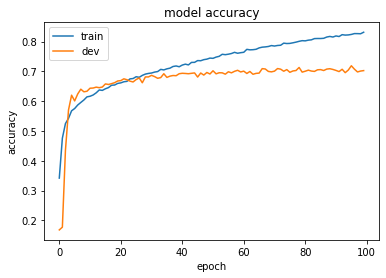

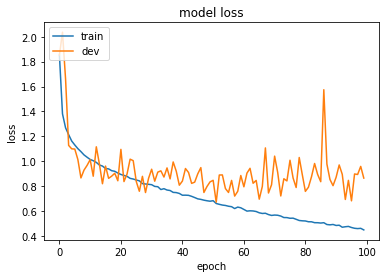

In [ ]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper left')
plt.show()

In [ ]:
epoch_str = '-EPOCHS_' + str(EPOCHS)
test_acc = 'test_acc_%.3f' % results_test[1]
model.save('/content/drive/My Drive/Facial Expression/Facial_Expression/models/' + 'RESNET50' + epoch_str + test_acc + '.h5')